<a href="https://colab.research.google.com/github/Tstrebe2/umich-mads-capstone-project/blob/tim-branch/tim-initial-model-lenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

!{sys.executable} -m pip install pydicom -q

     |████████████████████████████████| 2.0 MB 29.4 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython.display import clear_output

path = '/content/drive/MyDrive/capstone/assets/stage_2_train_images.zip'

!unzip {path}
clear_output(wait=True)

In [176]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.optim import SGD
import torch
import torchvision
import pydicom as dicom
from PIL import Image

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import os

In [214]:
class CustomImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, indices=None, transform=None, target_transform=None):
    if indices:
      self.img_labels = pd.read_csv(annotations_file).iloc[indices]
    else:
      self.img_labels = pd.read_csv(annotations_file)

    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = ''.join([os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]), '.dcm'])
    
    image = dicom.dcmread(os.path.join(self.img_dir, img_path))
    image = Image.fromarray(image.pixel_array)

    label = self.img_labels.iloc[idx, -1]

    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

  def get_classes(self):
    return self.img_labels.iloc[:, -1].unique()

  classes = property(get_classes)

In [215]:
annotations_file = '/content/drive/MyDrive/capstone/assets/stage_2_train_labels.csv.zip'
img_dir = '/content'

label_df = pd.read_csv(annotations_file)

X_train, X_test = train_test_split(label_df, test_size=.7, stratify=label_df.Target, random_state=99)
X_train, X_val, = train_test_split(X_train, test_size=.6, stratify=X_train.Target, random_state=99)
X_train, X_val, X_test = X_train.index.tolist(), X_val.index.tolist(), (X_test
                                                                        .groupby('Target')
                                                                        .apply(lambda grp: grp.sample(2000, random_state=99))
                                                                        .droplevel(0)
                                                                        .index
                                                                        .tolist())
# This dataset is for a proof of concept only. This small of an amount of data would likely
# cause a CNN to overfit.
len(X_train), len(X_val),  len(X_test)

(3627, 5441, 4000)

In [228]:
mean = 0.4968
std = 0.2491
transforms = dict(
  train = torchvision.transforms.Compose([
      torchvision.transforms.Resize(256),
      torchvision.transforms.RandomHorizontalFlip(.1),
      torchvision.transforms.RandomRotation(degrees=(-7, 7)),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(mean, std),
  ]),
  eval = torchvision.transforms.Compose([
      torchvision.transforms.Resize(256),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(mean, std),
  ])
)

train_dataset = CustomImageDataset(annotations_file, img_dir, indices=X_train, transform=transforms['train'])
val_dataset = CustomImageDataset(annotations_file, img_dir, indices=X_val, transform=transforms['eval'])
test_dataset = CustomImageDataset(annotations_file, img_dir, indices=X_test, transform=transforms['eval'])

In [229]:
batch_size = 32

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size)

print('training steps per epoch:', len(train_data_loader.dataset)//batch_size)
print('validation steps per epoch:', len(val_data_loader.dataset)//batch_size)

training steps per epoch: 113
validation steps per epoch: 170


In [220]:
# Uncomment and run to get mean and standard deviation
# for x, y in train_data_loader:
#   break

# x.mean(), x.std()

tensor(0.2491)

In [230]:
class LeNet(torch.nn.Module):
  def __init__(self, num_channels, classes):
    super(LeNet, self).__init__()

    self.conv1 = torch.nn.Conv2d(in_channels=num_channels, out_channels=20, kernel_size=20)
    self.relu1 = torch.nn.ReLU()
    self.maxpool1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    self.conv2 = torch.nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
    self.relu2 = torch.nn.ReLU()
    self.maxpool2 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
    
    self.fc1 = torch.nn.Linear(in_features=162450, out_features=500)
    self.relu3 = torch.nn.ReLU()
    
    self.fc2 = torch.nn.Linear(in_features=500, out_features=classes)
    self.logSoftmax = torch.nn.LogSoftmax(dim=1)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.maxpool1(x)

    x = self.conv2(x)
    x = self.relu2(x)
    x = self.maxpool2(x)

    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = self.relu3(x)

    x = self.fc2(x)
    output = self.logSoftmax(x)

    return output

init_learning_rate = 1e-3
epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LeNet(num_channels=1, classes=len(train_data_loader.dataset.classes)).to(device)

opt = SGD(model.parameters(), lr=init_learning_rate)
loss_fn = torch.nn.NLLLoss()

In [231]:
for e in range(epochs):
  model.train()

  total_training_loss = 0
  total_val_loss = 0

  train_correct = 0
  val_correct = 0

  for x, y in train_data_loader:
    x, y = x.to(device), y.to(device)

    pred = model(x)
    loss = loss_fn(pred, y)

    opt.zero_grad()
    loss.backward()
    opt.step()

    total_training_loss += loss
    train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  with torch.no_grad():
    model.eval()

    for (x, y) in val_data_loader:
      (x, y) = (x.to(device), y.to(device))
      pred = model(x)
      total_val_loss += loss_fn(pred, y)
      val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  print('Epoch {} completed - train loss: {:.4f} train correct pred: {} val loss {:4f} val correct pred: {}'.format(
      e+1, total_training_loss, train_correct, total_val_loss, val_correct
  ))

Epoch 1 completed - train loss: 63.4209 train correct pred: 2548.0 val loss 87.281425 val correct pred: 3975.0
Epoch 2 completed - train loss: 58.2254 train correct pred: 2702.0 val loss 86.811691 val correct pred: 4093.0
Epoch 3 completed - train loss: 57.5453 train correct pred: 2724.0 val loss 83.652679 val correct pred: 4142.0
Epoch 4 completed - train loss: 56.8876 train correct pred: 2738.0 val loss 85.525261 val correct pred: 4032.0
Epoch 5 completed - train loss: 56.7267 train correct pred: 2748.0 val loss 84.539215 val correct pred: 4076.0
Epoch 6 completed - train loss: 56.2361 train correct pred: 2762.0 val loss 82.056427 val correct pred: 4164.0
Epoch 7 completed - train loss: 55.6647 train correct pred: 2781.0 val loss 85.103943 val correct pred: 4120.0
Epoch 8 completed - train loss: 55.2262 train correct pred: 2790.0 val loss 81.829437 val correct pred: 4147.0
Epoch 9 completed - train loss: 55.1241 train correct pred: 2789.0 val loss 81.445152 val correct pred: 4185.0
E

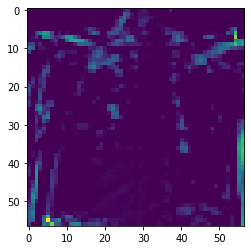

In [232]:
x = next(iter(test_dataset))[0].to(device)
x.resize_(1, 1, 256, 256)

with torch.no_grad():
  model.eval()
  x = model.conv1(x)
  x = model.relu1(x)
  x = model.maxpool1(x)

  x = model.conv2(x)
  x = model.relu2(x)
  x = model.maxpool2(x)

plt.imshow(x[0][0].cpu())

In [233]:
test_data_loader =  DataLoader(test_dataset, batch_size=batch_size)

y_s = torch.Tensor().to(device)
preds = torch.Tensor(0, 2).to(device)

with torch.no_grad():
  model.eval()
  for i, (x, y) in enumerate(test_data_loader):
    x, y = x.to(device), y.to(device)

    pred = model(x)

    preds = torch.vstack((preds, pred))
    y_s = torch.cat((y_s, y), dim=0)

print('n true:', y_s.shape[0])
print('n predictions:', preds.shape[0])

n true: 4000
n predictions: 4000


precision:	0.8258
recall:		0.5050
f1:		0.6267



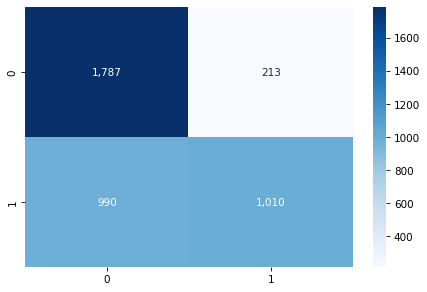

In [234]:
y_true = y_s.cpu().numpy()
y_pred = preds.cpu().numpy().argmax(axis=1)
y_proba = preds.cpu().numpy()[:, 1]

precision = metrics.precision_score(y_true, y_pred)
recall = metrics.recall_score(y_true, y_pred)
f1 = metrics.f1_score(y_true, y_pred)

print('precision:\t{:.4f}'.format(precision))
print('recall:\t\t{:.4f}'.format(recall))
print('f1:\t\t{:.4f}'.format(f1))
print()

fig = plt.figure(dpi=75)
ax = plt.gca()
sns.heatmap(metrics.confusion_matrix(y_true, y_pred), annot=True, fmt=',', cmap='Blues')
fig.tight_layout()
fig.show()

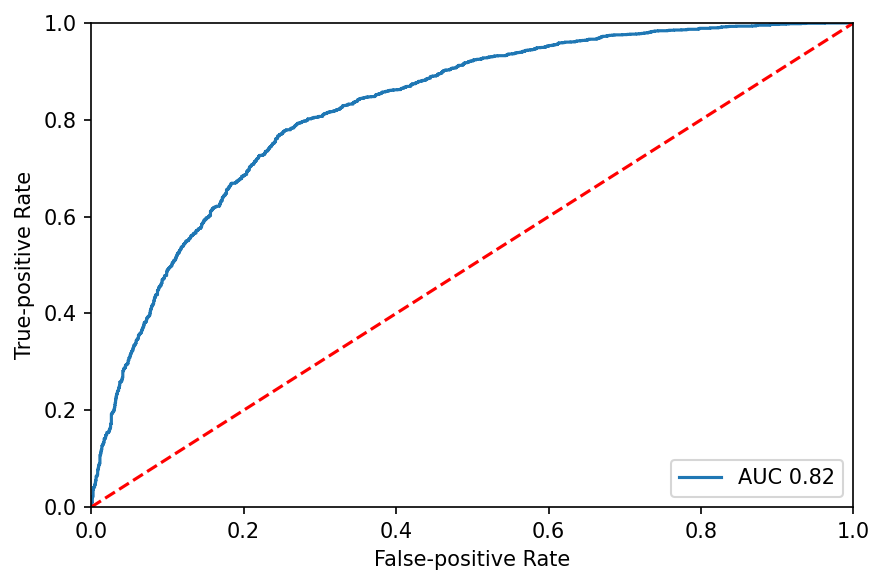

In [237]:
fpr, tpr, _ = metrics.roc_curve(y_true, y_proba)
roc_auc_score = metrics.roc_auc_score(y_true, y_proba)

no_skill = np.linspace(0, 1, 100)

plt.figure(dpi=150)
plt.plot(fpr, tpr, label='AUC {:.2f}'.format(roc_auc_score))
plt.plot(no_skill, no_skill, '--r')
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.ylabel('True-positive Rate')
plt.xlabel('False-positive Rate')
plt.tight_layout()
plt.show()

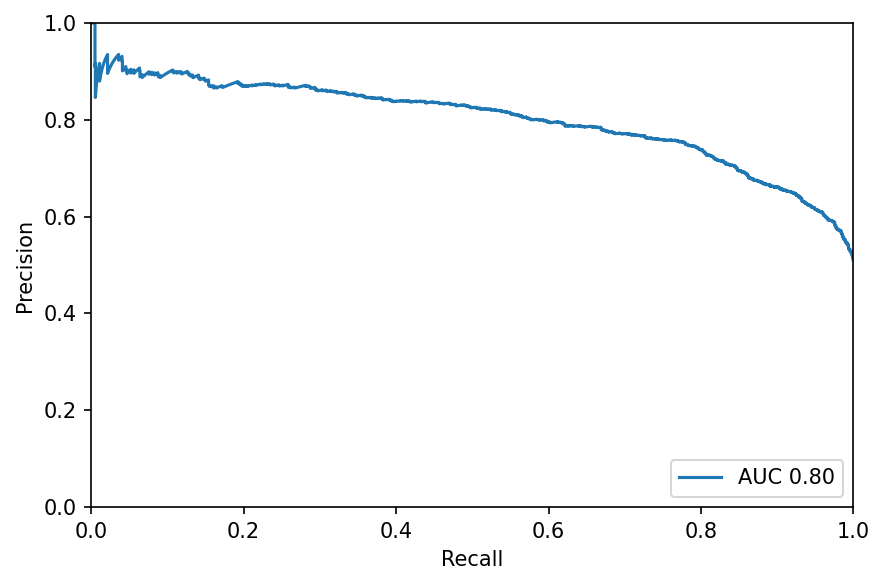

In [236]:
precision, recall, _ = metrics.precision_recall_curve(y_true, y_proba)
auprc_score = metrics.auc(recall, precision)

plt.figure(dpi=150)
plt.plot(recall, precision, label='AUC {:.2f}'.format(auprc_score))
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.tight_layout()
plt.show()